In [1]:
import numpy as np
import h5py
import string
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# Meta data of papers
class PaperMeta(object):
    def __init__(self, title, abstract, keyword, rating, url, withdrawn):
        self.title = title  # str
        self.abstract = abstract  # str
        self.keyword = keyword  # list[str]
        self.rating = rating  # list[int]
        self.url = url
        self.withdrawn = withdrawn
        
        if len(self.rating) > 0:
            self.average_rating = np.mean(rating)
        else:
            self.average_rating = -1

            
class Keyword(object):
    def __init__(self, keyword, frequency, rating):
        self.keyword = keyword  # list[str]
        self.frequency = frequency
        self.rating = rating  # list[int]        
    
    def average_rating(self):
        if len(self.rating) > 0:
            return np.mean(self.rating)
        else:
            return -1
    
    def update_frequency(self, frequency):
        self.frequency += frequency
        
    def update_rating(self, rating):
        self.rating = np.concatenate((self.rating, rating))
            
            
def write_meta(meta_list, filename):
    f = h5py.File(filename, 'w')
    for i, m in enumerate(meta_list):
        grp = f.create_group(str(i))
        grp['title'] = m.title
        grp['abstract'] = m.abstract
        grp['keyword'] = '#'.join(m.keyword)
        grp['rating'] = m.rating
        grp['url'] = m.url
        grp['withdrawn'] = m.withdrawn        
    f.close()
    
    
def read_meta(filename):
    f = h5py.File(filename, 'r')
    meta_list = []
    for k in list(f.keys()):
        meta_list.append(PaperMeta(
            f[k]['title'].value, 
            f[k]['abstract'].value, 
            f[k]['keyword'].value.split('#'),
            f[k]['rating'].value,
            f[k]['url'].value,
            f[k]['withdrawn'].value,            
        ))
    return meta_list


def crawl_meta(meta_hdf5=None, write_meta_name='data.hdf5'):
    
    if meta_hdf5 is None:
        # Crawl the meta data from OpenReview
        # Set up a browser to crawl from dynamic web pages 
        from selenium import webdriver
        from selenium.webdriver.chrome.options import Options
        
        from pyvirtualdisplay import Display
        display = Display(visible=0, size=(800, 800))
        display.start()
        
        import time
        executable_path = '/usr/local/bin/chromedriver'
        options = Options()
        options.add_argument("--headless")
        browser = webdriver.Chrome(options=options, executable_path=executable_path)            
    
        # Load all URLs for all ICLR submissions
        urls = []
        with open('urls.txt') as f:
            urls = f.readlines()
        urls = [url.strip() for url in urls]
        
        meta_list = [] 
        wait_time = 0.5
        max_try = 1000
        for i, url in enumerate(urls):
            # try:
            browser.get(url)
            time.sleep(wait_time)
            key = browser.find_elements_by_class_name("note_content_field")
            key = [k.text for k in key]
            withdrawn = 'Withdrawal confirmation:' in key
            value = browser.find_elements_by_class_name("note_content_value")
            value = [v.text for v in value]

            # title
            title = string.capwords(browser.find_element_by_class_name("note_content_title").text)
            # abstract
            valid = False
            tries = 0
            while not valid:
                if 'Abstract:' in key:
                    valid = True
                else:
                    time.sleep(wait_time)
                    tries += 1
                    if tries >= max_try:
                        print('Reached max try: {} ({})'.format(title, url))
                        break
            abstract = ' '.join(value[key.index('Abstract:')].split('\n'))
            # keyword
            if 'Keywords:' in key:
                keyword = value[key.index('Keywords:')].split(',')
                keyword = [k.strip(' ') for k in keyword]
                keyword = [''.join(string.capwords(k).split(' ')) for k in keyword if not k == '']
                for j in range(len(keyword)):
                    if '-' in keyword[j]:
                        keyword[j] = ''.join([string.capwords(kk) for kk in keyword[j].split('-')])       
            else:
                keyword = []
            # rating
            rating_idx = [i for i, x in enumerate(key) if x == "Rating:"]
            rating = []
            if len(rating_idx) > 0:
                for idx in rating_idx:
                    rating.append(int(value[idx].split(":")[0]))
            print('[{}] [Abs: {} chars, keywords: {}, ratings: {}] {}'.format(
                i, len(abstract), len(keyword), rating, title))
            meta_list.append(PaperMeta(title, abstract, keyword, rating, url, withdrawn))
            # except:
            #     print('Failed to load {}'.format(url))
            
        # Save the crawled data
        write_meta(meta_list, write_meta_name)
    else:
        # Load the meta data from local
        meta_list = read_meta(meta_hdf5)
    return meta_list

In [3]:
# Get the meta data
# Uncomment this if you want to load the previously stored data file
# meta_list, _ = crawl_meta('data.hdf5')
# Uncomment this if you want to cral data from scratch
meta_list = crawl_meta()
num_withdrawn = len([m for m in meta_list if m.withdrawn])
print('Number of submissions: {} (withdrwan submissions: {})'.format(
    len(meta_list), num_withdrawn))

[0] [Abs: 1587 chars, keywords: 4, ratings: [4, 5, 3]] Layerwise Recurrent Autoencoder For General Real-world Traffic Flow Forecasting
[1] [Abs: 1460 chars, keywords: 3, ratings: [6, 5, 8]] Machine Translation With Weakly Paired Bilingual Documents
[2] [Abs: 1110 chars, keywords: 3, ratings: [4, 4, 5]] Select Via Proxy: Efficient Data Selection For Training Deep Networks
[3] [Abs: 825 chars, keywords: 3, ratings: [6, 7, 5]] Hierarchical Reinforcement Learning With Limited Policies And Hindsight
[4] [Abs: 1040 chars, keywords: 1, ratings: [4, 5, 5]] Accelerated Sparse Recovery Under Structured Measurements
[5] [Abs: 1124 chars, keywords: 2, ratings: [7, 5, 8]] Deep Layers As Stochastic Solvers
[6] [Abs: 1271 chars, keywords: 2, ratings: [6, 6, 6]] Instance-aware Image-to-image Translation
[7] [Abs: 1385 chars, keywords: 2, ratings: [3, 6, 4]] From Adversarial Training To Generative Adversarial Networks
[8] [Abs: 973 chars, keywords: 3, ratings: [4, 4, 4]] Continual Learning Via Explicit

[71] [Abs: 1098 chars, keywords: 11, ratings: [6, 7, 6]] Go Gradient For Expectation-based Objectives
[72] [Abs: 1894 chars, keywords: 4, ratings: [5, 4, 3]] On The Statistical And Information Theoretical Characteristics Of Dnn Representations
[73] [Abs: 1651 chars, keywords: 0, ratings: [5, 4, 5]] Characterizing Vulnerabilities Of Deep Reinforcement Learning
[74] [Abs: 1395 chars, keywords: 5, ratings: [6, 7]] Defensive Quantization: When Efficiency Meets Robustness
[75] [Abs: 1655 chars, keywords: 5, ratings: [4, 5, 5]] Conditional Network Embeddings
[76] [Abs: 1101 chars, keywords: 4, ratings: [7, 4, 4]] Nattack: A Strong And Universal Gaussian Black-box Adversarial Attack
[77] [Abs: 1120 chars, keywords: 5, ratings: [4, 6]] Representation-constrained Autoencoders And An Application To Wireless Positioning
[78] [Abs: 739 chars, keywords: 4, ratings: [6, 6]] Incremental Training Of Multi-generative Adversarial Networks
[79] [Abs: 1021 chars, keywords: 4, ratings: [6, 5, 5]] Playing T

[140] [Abs: 1140 chars, keywords: 4, ratings: [6, 4, 3]] Learning Corresponded Rationales For Text Matching
[141] [Abs: 870 chars, keywords: 5, ratings: [3, 3, 4]] Understanding And Improving Sequence-labeling Ner With Self-attentive Lstms
[142] [Abs: 1617 chars, keywords: 1, ratings: [4, 3, 3]] She2: Stochastic Hamiltonian Exploration And Exploitation For Derivative-free Optimization
[143] [Abs: 1317 chars, keywords: 3, ratings: [4, 4, 4]] Exploiting Invariant Structures For Compression In Neural Networks
[144] [Abs: 1332 chars, keywords: 2, ratings: [6, 5]] Probabilistic Recursive Reasoning For Multi-agent Reinforcement Learning
[145] [Abs: 1213 chars, keywords: 0, ratings: [4, 3, 5]] Dual Importance Weight Gan
[146] [Abs: 1486 chars, keywords: 3, ratings: [4, 6, 3]] Optimal Attacks Against Multiple Classifiers
[147] [Abs: 1119 chars, keywords: 4, ratings: [5, 6, 4]] Network Compression Using Correlation Analysis Of Layer Responses
[148] [Abs: 731 chars, keywords: 0, ratings: [5, 5, 

[207] [Abs: 1506 chars, keywords: 5, ratings: [5, 5, 7]] Nested Dithered Quantization For Communication Reduction In Distributed Training
[208] [Abs: 959 chars, keywords: 7, ratings: [6, 7, 7]] Hyperbolic Attention Networks
[209] [Abs: 989 chars, keywords: 6, ratings: [6, 5, 5]] Knows When It Doesn’t Know: Deep Abstaining Classifiers
[210] [Abs: 603 chars, keywords: 3, ratings: [4, 4, 3]] Inhibited Softmax For Uncertainty Estimation In Neural Networks
[211] [Abs: 434 chars, keywords: 4, ratings: [4, 3, 7]] Holographic And Other Point Set Distances For Machine Learning
[212] [Abs: 1360 chars, keywords: 4, ratings: [6, 5, 6]] Rethinking The Value Of Network Pruning
[213] [Abs: 1506 chars, keywords: 4, ratings: [7, 6, 7]] Query-efficient Hard-label Black-box Attack: An Optimization-based Approach
[214] [Abs: 1181 chars, keywords: 3, ratings: [7, 5, 7]] Diversity-sensitive Conditional Generative Adversarial Networks
[215] [Abs: 1515 chars, keywords: 2, ratings: [5, 4, 5]] Penetrating The F

[273] [Abs: 1150 chars, keywords: 0, ratings: [6, 6, 7]] On Computation And Generalization Of Generative Adversarial Networks Under Spectrum Control
[274] [Abs: 914 chars, keywords: 3, ratings: [5, 3, 7]] On Accurate Evaluation Of Gans For Language Generation
[275] [Abs: 793 chars, keywords: 3, ratings: [3, 4, 4]] Explaining Alphago: Interpreting Contextual Effects In Neural Networks
[276] [Abs: 1306 chars, keywords: 4, ratings: [4, 8, 4]] A Deep Learning Approach For Dynamic Survival Analysis With Competing Risks
[277] [Abs: 878 chars, keywords: 8, ratings: [5, 2, 7]] Reduced-gate Convolutional Lstm Design Using Predictive Coding For Next-frame Video Prediction
[278] [Abs: 1493 chars, keywords: 2, ratings: [7, 7, 9]] Learning Robust Representations By Projecting Superficial Statistics Out
[279] [Abs: 1042 chars, keywords: 3, ratings: [4, 3, 4]] An Attention-based Model For Learning Dynamic Interaction Networks
[280] [Abs: 1672 chars, keywords: 4, ratings: [4, 5, 5]] Ssoc: Learning Spo

[341] [Abs: 1120 chars, keywords: 4, ratings: [6, 6]] Characterizing Audio Adversarial Examples Using Temporal Dependency
[342] [Abs: 837 chars, keywords: 3, ratings: [6, 5, 4]] Using Ontologies To Improve Performance In Massively Multi-label Prediction
[343] [Abs: 1291 chars, keywords: 3, ratings: []] Neural Collobrative Networks
[344] [Abs: 937 chars, keywords: 3, ratings: [4]] Sample-efficient Policy Learning In Multi-agent Reinforcement Learning Via Meta-learning
[345] [Abs: 1098 chars, keywords: 3, ratings: [4, 4, 4]] Learning To Search Efficient Densenet With Layer-wise Pruning
[346] [Abs: 1074 chars, keywords: 3, ratings: [3, 4, 5]] Semantic Parsing Via Cross-domain Schema
[347] [Abs: 593 chars, keywords: 5, ratings: [6, 5, 6]] Overcoming Neural Brainwashing
[348] [Abs: 1159 chars, keywords: 3, ratings: [5, 5, 5]] Graph Transformation Policy Network For Chemical Reaction Prediction
[349] [Abs: 1642 chars, keywords: 6, ratings: [7, 6, 7]] Minimal Random Code Learning: Getting Bit

[410] [Abs: 871 chars, keywords: 4, ratings: [6, 7, 8]] Robustness May Be At Odds With Accuracy
[411] [Abs: 1281 chars, keywords: 3, ratings: [3, 3, 2]] A Case Study On Optimal Deep Learning Model For Uavs
[412] [Abs: 1299 chars, keywords: 3, ratings: [8, 4, 9]] Invariant And Equivariant Graph Networks
[413] [Abs: 1846 chars, keywords: 3, ratings: [8, 6, 5]] Universal Stagewise Learning For Non-convex Problems With Convergence On Averaged Solutions
[414] [Abs: 1614 chars, keywords: 3, ratings: [5, 3, 4]] Polar Prototype Networks
[415] [Abs: 1435 chars, keywords: 0, ratings: [8, 6, 6]] Learning Grid-like Units With Vector Representation Of Self-position And Matrix Representation Of Self-motion
[416] [Abs: 1108 chars, keywords: 0, ratings: [5, 7, 6]] Image Deformation Meta-network For One-shot Learning
[417] [Abs: 718 chars, keywords: 4, ratings: []] Program Synthesis With Learned Code Idioms
[418] [Abs: 1058 chars, keywords: 2, ratings: [5, 5, 7]] Adaptive Network Sparsification Via Dep

[480] [Abs: 877 chars, keywords: 3, ratings: [7, 7, 7]] Cot: Cooperative Training For Generative Modeling Of Discrete Data
[481] [Abs: 677 chars, keywords: 0, ratings: [5, 5, 4]] Online Bellman Residue Minimization Via Saddle Point Optimization
[482] [Abs: 1771 chars, keywords: 4, ratings: [5, 4]] Relwalk -- A Latent Variable Model Approach To Knowledge Graph Embedding
[483] [Abs: 1205 chars, keywords: 7, ratings: [5, 5, 6]] Improving Composition Of Sentence Embeddings Through The Lens Of Statistical Relational Learning
[484] [Abs: 915 chars, keywords: 4, ratings: [3, 1, 3]] Pixel Chem: A Representation For Predicting Material Properties With Neural Network
[485] [Abs: 1242 chars, keywords: 2, ratings: [5, 6, 4]] An Automatic Operation Batching Strategy For The Backward Propagation Of Neural Networks Having Dynamic Computation Graphs
[486] [Abs: 1314 chars, keywords: 9, ratings: [8, 8, 5]] Don't Settle For Average, Go For The Max: Fuzzy Sets And Max-pooled Word Vectors
[487] [Abs: 949 

[550] [Abs: 952 chars, keywords: 4, ratings: [8, 7, 8]] Pay Less Attention With Lightweight And Dynamic Convolutions
[551] [Abs: 1062 chars, keywords: 0, ratings: [5, 4, 4]] Beyond Winning And Losing: Modeling Human Motivations And Behaviors With Vector-valued Inverse Reinforcement Learning
[552] [Abs: 1082 chars, keywords: 5, ratings: [4, 4, 4]] Differentially Private Federated Learning: A Client Level Perspective
[553] [Abs: 739 chars, keywords: 4, ratings: [8, 5, 6]] Fluctuation-dissipation Relations For Stochastic Gradient Descent
[554] [Abs: 911 chars, keywords: 8, ratings: [3, 4, 6]] Open Vocabulary Learning On Source Code With A Graph-structured Cache
[555] [Abs: 1025 chars, keywords: 3, ratings: [3, 1, 3]] Training Variational Auto Encoders With Discrete Latent Representations Using Importance Sampling
[556] [Abs: 885 chars, keywords: 5, ratings: [4, 3, 4]] Delibgan: Coarse-to-fine Text Generation Via Adversarial Network
[557] [Abs: 1527 chars, keywords: 7, ratings: [5, 5, 5]] 

[617] [Abs: 842 chars, keywords: 4, ratings: [5, 3, 6]] Exploiting Environmental Variation To Improve Policy Robustness In Reinforcement Learning
[618] [Abs: 833 chars, keywords: 11, ratings: [8, 5, 6]] Learning Latent Superstructures In Variational Autoencoders For Deep Multidimensional Clustering
[619] [Abs: 821 chars, keywords: 3, ratings: [4, 8, 7]] Camou: Learning Physical Vehicle Camouflages To Adversarially Attack Detectors In The Wild
[620] [Abs: 858 chars, keywords: 5, ratings: [6, 4, 3]] On The Convergence And Robustness Of Batch Normalization
[621] [Abs: 1419 chars, keywords: 4, ratings: [5, 4, 5]] Neural Malware Control With Deep Reinforcement Learning
[622] [Abs: 1249 chars, keywords: 4, ratings: [3, 6]] Teaching To Teach By Structured Dark Knowledge
[623] [Abs: 1751 chars, keywords: 0, ratings: [5, 5, 3]] Realistic Adversarial Examples In 3d Meshes
[624] [Abs: 999 chars, keywords: 2, ratings: [7, 5, 7]] Bias-reduced Uncertainty Estimation For Deep Neural Classifiers
[625]

[685] [Abs: 782 chars, keywords: 5, ratings: [3, 7]] Arm: Augment-reinforce-merge Gradient For Stochastic Binary Networks
[686] [Abs: 1390 chars, keywords: 3, ratings: [5, 4, 4]] From Nodes To Networks: Evolving Recurrent Neural Networks
[687] [Abs: 1451 chars, keywords: 3, ratings: [6, 5, 8]] Exemplar Guided Unsupervised Image-to-image Translation With Semantic Consistency
[688] [Abs: 1227 chars, keywords: 5, ratings: [4, 7]] Perception-aware Point-based Value Iteration For Partially Observable Markov Decision Processes
[689] [Abs: 1254 chars, keywords: 3, ratings: [5, 6, 7]] Combinatorial Attacks On Binarized Neural Networks
[690] [Abs: 976 chars, keywords: 5, ratings: [5, 4, 3]] Empirically Characterizing Overparameterization Impact On Convergence
[691] [Abs: 709 chars, keywords: 6, ratings: [7, 6, 6]] Improved Gradient Estimators For Stochastic Discrete Variables
[692] [Abs: 1021 chars, keywords: 3, ratings: [5, 7, 6]] A Direct Approach To Robust Deep Learning Using Adversarial Net

[754] [Abs: 1442 chars, keywords: 4, ratings: [6, 2, 6]] Learning To Adapt In Dynamic, Real-world Environments Through Meta-reinforcement Learning
[755] [Abs: 1761 chars, keywords: 6, ratings: [6, 6, 7]] Universal Transformers
[756] [Abs: 1467 chars, keywords: 3, ratings: [8, 5, 5]] Proxquant: Quantized Neural Networks Via Proximal Operators
[757] [Abs: 1766 chars, keywords: 3, ratings: [8, 5, 8]] Learning Self-imitating Diverse Policies
[758] [Abs: 1132 chars, keywords: 0, ratings: [4, 4, 4]] Data Poisoning Attack Against Node Embedding Methods
[759] [Abs: 1203 chars, keywords: 5, ratings: [5, 4, 5]] An Energy-based Framework For Arbitrary Label Noise Correction
[760] [Abs: 1308 chars, keywords: 3, ratings: [7, 5, 5]] Adversarial Exploration Strategy For Self-supervised Imitation Learning
[761] [Abs: 1135 chars, keywords: 6, ratings: [5, 5, 5]] On The Effectiveness Of Task Granularity For Transfer Learning
[762] [Abs: 1265 chars, keywords: 7, ratings: [5, 4, 4]] Modulating Transfer Be

[821] [Abs: 1124 chars, keywords: 3, ratings: [4, 5, 4]] Nice: Noise Injection And Clamping Estimation For Neural Network Quantization
[822] [Abs: 1106 chars, keywords: 5, ratings: [7, 6, 7]] Solving The Rubik's Cube With Approximate Policy Iteration
[823] [Abs: 614 chars, keywords: 0, ratings: [6, 5, 7]] Temporal Gaussian Mixture Layer For Videos
[824] [Abs: 1062 chars, keywords: 4, ratings: [5, 4]] Pruning With Hints: An Efficient Framework For Model Acceleration
[825] [Abs: 845 chars, keywords: 3, ratings: [5, 6, 5]] Scalable Unbalanced Optimal Transport Using Generative Adversarial Networks
[826] [Abs: 1205 chars, keywords: 0, ratings: [5, 4, 6]] A Frank-wolfe Framework For Efficient And Effective Adversarial Attacks
[827] [Abs: 995 chars, keywords: 4, ratings: [4, 5, 5]] Integral Pruning On Activations And Weights For Efficient Neural Networks
[828] [Abs: 893 chars, keywords: 4, ratings: [4, 7, 5]] I Know The Feeling: Learning To Converse With Empathy
[829] [Abs: 1041 chars, keywo

[889] [Abs: 1113 chars, keywords: 4, ratings: [5, 6]] Accelerated Gradient Flow For Probability Distributions
[890] [Abs: 555 chars, keywords: 5, ratings: [6, 6, 3]] Improved Robustness To Adversarial Examples Using Lipschitz Regularization Of The Loss
[891] [Abs: 1361 chars, keywords: 5, ratings: [5, 4, 4]] The Cakewalk Method
[892] [Abs: 577 chars, keywords: 1, ratings: [5, 6, 6]] Super-resolution Via Conditional Implicit Maximum Likelihood Estimation
[893] [Abs: 1313 chars, keywords: 6, ratings: [4, 6, 4]] Approximation And Non-parametric Estimation Of Resnet-type Convolutional Neural Networks Via Block-sparse Fully-connected Neural Networks
[894] [Abs: 1401 chars, keywords: 5, ratings: [3, 5, 4]] Unsupervised Convolutional Neural Networks For Accurate Video Frame Interpolation With Integration Of Motion Components
[895] [Abs: 1230 chars, keywords: 3, ratings: [5, 6, 3]] Marginalized Average Attentional Network For Weakly-supervised Learning
[896] [Abs: 1075 chars, keywords: 3, rati

[956] [Abs: 869 chars, keywords: 2, ratings: [6, 6, 6]] Datnet: Dual Adversarial Transfer For Low-resource Named Entity Recognition
[957] [Abs: 1500 chars, keywords: 4, ratings: [4, 5, 5]] Batch Normalization Sampling
[958] [Abs: 1478 chars, keywords: 6, ratings: [6, 5, 5]] Generalization And Regularization In Dqn
[959] [Abs: 1629 chars, keywords: 3, ratings: [4, 4, 3]] Improving Adversarial Discriminative Domain Adaptation
[960] [Abs: 1130 chars, keywords: 3, ratings: [4, 6, 5]] Pyramid Recurrent Neural Networks For Multi-scale Change-point Detection
[961] [Abs: 1060 chars, keywords: 0, ratings: [3, 3, 3]] An Analysis Of Composite Neural Network Performance From Function Composition Perspective
[962] [Abs: 1060 chars, keywords: 4, ratings: [7, 3, 4]] Towards A Better Understanding Of Vector Quantized Autoencoders
[963] [Abs: 1536 chars, keywords: 6, ratings: [7, 7, 6]] Doubly Reparameterized Gradient Estimators For Monte Carlo Objectives
[964] [Abs: 859 chars, keywords: 3, ratings: [6

[1024] [Abs: 1320 chars, keywords: 5, ratings: [5, 5, 6]] Mimicking Actions Is A Good Strategy For Beginners: Fast Reinforcement Learning With Expert Action Sequences
[1025] [Abs: 949 chars, keywords: 0, ratings: [6, 6, 5]] Data-dependent Coresets For Compressing Neural Networks With Applications To Generalization Bounds
[1026] [Abs: 969 chars, keywords: 5, ratings: [7, 9, 6]] Gradient Descent Aligns The Layers Of Deep Linear Networks
[1027] [Abs: 1662 chars, keywords: 0, ratings: [7, 6, 7]] Active Learning With Partial Feedback
[1028] [Abs: 1275 chars, keywords: 8, ratings: [5, 5, 5]] On The Learning Dynamics Of Deep Neural Networks
[1029] [Abs: 1670 chars, keywords: 5, ratings: [7, 4, 5]] Stochastic Gradient/mirror Descent: Minimax Optimality And Implicit Regularization
[1030] [Abs: 796 chars, keywords: 4, ratings: [6, 6, 5]] State-regularized Recurrent Networks
[1031] [Abs: 628 chars, keywords: 3, ratings: [4, 5, 3]] A Generalized Active Learning Approach For Unsupervised Anomaly De

[1095] [Abs: 960 chars, keywords: 4, ratings: [6, 7, 8]] Gansynth: Adversarial Neural Audio Synthesis
[1096] [Abs: 978 chars, keywords: 3, ratings: [5, 5, 5]] Excitation Dropout: Encouraging Plasticity In Deep Neural Networks
[1097] [Abs: 914 chars, keywords: 5, ratings: [4, 4, 5]] Robust Text Classifier On Test-time Budgets
[1098] [Abs: 1635 chars, keywords: 3, ratings: [5, 3, 3]] Gradmix: Multi-source Transfer Across Domains And Tasks
[1099] [Abs: 965 chars, keywords: 4, ratings: [7, 4, 6]] Convolutional Crfs For Semantic Segmentation
[1100] [Abs: 768 chars, keywords: 3, ratings: [4, 4, 9]] The Problem Of Model Completion
[1101] [Abs: 924 chars, keywords: 2, ratings: [5, 6, 6]] Minimum Divergence Vs. Maximum Margin: An Empirical Comparison On Seq2seq Models
[1102] [Abs: 913 chars, keywords: 6, ratings: [4, 7]] Generative Adversarial Models For Learning Private And Fair Representations
[1103] [Abs: 1459 chars, keywords: 5, ratings: [6, 3]] A Better Baseline For Second Order Gradient E

[1163] [Abs: 762 chars, keywords: 3, ratings: [8, 6, 6]] Stochastic Optimization Of Sorting Networks Via Continuous Relaxations
[1164] [Abs: 1405 chars, keywords: 3, ratings: [4, 4, 5]] Low-cost Parameterizations Of Deep Convolutional Neural Networks
[1165] [Abs: 1666 chars, keywords: 4, ratings: [6, 4]] Unsupervised Meta-learning For Reinforcement Learning
[1166] [Abs: 924 chars, keywords: 4, ratings: [4, 5, 5]] Using Gans For Generation Of Realistic City-scale Ride Sharing/hailing Data Sets
[1167] [Abs: 1120 chars, keywords: 0, ratings: [4, 5, 6]] Adversarial Audio Super-resolution With Unsupervised Feature Losses
[1168] [Abs: 1252 chars, keywords: 5, ratings: [9, 5, 5]] Laplacian Networks: Bounding Indicator Function Smoothness For Neural Networks Robustness
[1169] [Abs: 1064 chars, keywords: 3, ratings: [5, 4, 4]] Efficient Sequence Labeling With Actor-critic Training
[1170] [Abs: 1025 chars, keywords: 0, ratings: [6, 6, 6]] Tarmac: Targeted Multi-agent Communication
[1171] [Abs: 1

[1228] [Abs: 1071 chars, keywords: 3, ratings: [5, 5, 3]] Meta-learning With Individualized Feature Space For Few-shot Classification
[1229] [Abs: 998 chars, keywords: 3, ratings: [3, 5, 4]] Defactor: Differentiable Edge Factorization-based Probabilistic Graph Generation
[1230] [Abs: 809 chars, keywords: 5, ratings: [9, 6]] Diffusion Scattering Transforms On Graphs
[1231] [Abs: 1180 chars, keywords: 2, ratings: [4, 4]] Mixture Of Pre-processing Experts Model For Noise Robust Deep Learning On Resource Constrained Platforms
[1232] [Abs: 699 chars, keywords: 1, ratings: [6, 8, 7]] Greedy Attack And Gumbel Attack: Generating Adversarial Examples For Discrete Data
[1233] [Abs: 1245 chars, keywords: 7, ratings: [4, 7, 6]] Imagenet-trained Cnns Are Biased Towards Texture; Increasing Shape Bias Improves Accuracy And Robustness.
[1234] [Abs: 756 chars, keywords: 4, ratings: [7]] The Role Of Over-parametrization In Generalization Of Neural Networks
[1235] [Abs: 1314 chars, keywords: 3, ratings: 

[1298] [Abs: 798 chars, keywords: 4, ratings: [5, 5, 5]] A Comprehensive, Application-oriented Study Of Catastrophic Forgetting In Dnns
[1299] [Abs: 1444 chars, keywords: 3, ratings: [8, 5, 8]] Unsupervised Domain Adaptation For Distance Metric Learning
[1300] [Abs: 753 chars, keywords: 4, ratings: [5, 8, 5]] Deep Convolutional Networks As Shallow Gaussian Processes
[1301] [Abs: 720 chars, keywords: 3, ratings: [7, 5, 5]] Unsupervised Learning Of Sentence Representations Using Sequence Consistency
[1302] [Abs: 1506 chars, keywords: 4, ratings: [6, 6, 6]] Accumulation Bit-width Scaling For Ultra-low Precision Training Of Deep Networks
[1303] [Abs: 807 chars, keywords: 2, ratings: [3, 3, 6]] Microgan: Promoting Variety Through Microbatch Discrimination
[1304] [Abs: 828 chars, keywords: 4, ratings: [4, 4, 4]] Mol-cyclegan - A Generative Model For Molecular Optimization
[1305] [Abs: 1280 chars, keywords: 2, ratings: [7, 4, 7]] Deep Lagrangian Networks: Using Physics As Model Prior For Deep

[1364] [Abs: 1338 chars, keywords: 4, ratings: [5, 5, 7]] (unconstrained) Beam Search Is Sensitive To Large Search Discrepancies
[1365] [Abs: 1262 chars, keywords: 4, ratings: [5, 5, 5]] Revisiting Reweighted Wake-sleep
[1366] [Abs: 1835 chars, keywords: 5, ratings: [4, 5, 6]] Scalable Neural Theorem Proving On Knowledge Bases And Natural Language
[1367] [Abs: 1485 chars, keywords: 5, ratings: [7, 8, 7]] Towards Metamerism Via Foveated Style Transfer
[1368] [Abs: 1136 chars, keywords: 3, ratings: [4, 4, 7]] Evading Defenses To Transferable Adversarial Examples By Mitigating Attention Shift
[1369] [Abs: 1270 chars, keywords: 3, ratings: [5, 4, 7]] Tangent-normal Adversarial Regularization For Semi-supervised Learning
[1370] [Abs: 1005 chars, keywords: 9, ratings: [7, 5, 8]] K For The Price Of 1: Parameter Efficient Multi-task And Transfer Learning
[1371] [Abs: 1180 chars, keywords: 5, ratings: [5, 7, 8]] Bounce And Learn: Modeling Scene Dynamics With Real-world Bounces
[1372] [Abs: 1183

[1431] [Abs: 654 chars, keywords: 6, ratings: [8, 6, 5]] A Rotation And A Translation Suffice: Fooling Cnns With Simple Transformations
[1432] [Abs: 1367 chars, keywords: 5, ratings: [4, 3, 4]] Feature Transformers: A Unified Representation Learning Framework For Lifelong Learning
[1433] [Abs: 619 chars, keywords: 5, ratings: [5, 5, 8]] Learning Kolmogorov Models For Binary Random Variables
[1434] [Abs: 790 chars, keywords: 4, ratings: [4, 6, 6]] Identifying Bias In Ai Using Simulation
[1435] [Abs: 799 chars, keywords: 0, ratings: [8, 6]] Hierarchical Visuomotor Control Of Humanoids
[1436] [Abs: 1163 chars, keywords: 5, ratings: [3, 6, 6]] Adversarial Information Factorization
[1437] [Abs: 1008 chars, keywords: 3, ratings: [6, 8, 4]] Learning To Learn With Conditional Class Dependencies
[1438] [Abs: 850 chars, keywords: 6, ratings: [8, 7, 4]] Training For Faster Adversarial Robustness Verification Via Inducing Relu Stability
[1439] [Abs: 1391 chars, keywords: 2, ratings: [5, 5, 4]] Vis

[1498] [Abs: 1100 chars, keywords: 4, ratings: [4, 3, 2]] Classification In The Dark Using Tactile Exploration
[1499] [Abs: 906 chars, keywords: 4, ratings: [4, 5, 3]] Overfitting Detection Of Deep Neural Networks Without A Hold Out Set
[1500] [Abs: 1256 chars, keywords: 0, ratings: [7, 6, 6]] Eidetic 3d Lstm: A Model For Video Prediction And Beyond
[1501] [Abs: 1303 chars, keywords: 8, ratings: [4, 6]] Intrinsic Social Motivation Via Causal Influence In Multi-agent Rl
[1502] [Abs: 1569 chars, keywords: 5, ratings: [7, 4, 2]] Mental Fatigue Monitoring Using Brain Dynamics Preferences
[1503] [Abs: 890 chars, keywords: 5, ratings: [5, 3, 5]] Backdrop: Stochastic Backpropagation
[1504] [Abs: 732 chars, keywords: 4, ratings: [4, 3, 3]] Learning And Data Selection In Big Datasets
[1505] [Abs: 789 chars, keywords: 4, ratings: [9, 7, 8]] Ordered Neurons: Integrating Tree Structures Into Recurrent Neural Networks
[1506] [Abs: 1224 chars, keywords: 0, ratings: [4, 4, 3]] A Walk With Sgd: How Sg

[1565] [Abs: 1468 chars, keywords: 3, ratings: [3, 8, 4]] Initialized Equilibrium Propagation For Backprop-free Training
[1566] [Abs: 1182 chars, keywords: 6, ratings: [3, 4, 4]] Unsupervised One-to-many Image Translation
[1567] [Abs: 727 chars, keywords: 4, ratings: [7, 4, 3]] Explicit Recall For Efficient Exploration
[1568] [Abs: 1324 chars, keywords: 2, ratings: [3, 4, 4]] Polycnn: Learning Seed Convolutional Filters
[1569] [Abs: 1211 chars, keywords: 3, ratings: [4, 4, 4]] Hypergan: Exploring The Manifold Of Neural Networks
[1570] [Abs: 1047 chars, keywords: 3, ratings: [6, 6, 6]] Variance Networks: When Expectation Does Not Meet Your Expectations
[1571] [Abs: 1977 chars, keywords: 4, ratings: [6, 3, 4]] Augmented Cyclic Adversarial Learning For Domain Adaptation
[1572] [Abs: 1686 chars, keywords: 4, ratings: [5, 7, 4]] Convolutional Neural Networks On Non-uniform Geometrical Signals Using Euclidean Spectral Transformation
[1573] [Abs: 993 chars, keywords: 4, ratings: [4, 3, 4]] Hi

In [4]:
rating = []
rating_mean = []
num_rating = []
keywords = []
for m in meta_list:
    rating.extend(m.rating)
    keywords.extend(m.keyword)
    if not m.withdrawn:
        num_rating.append(len(m.rating))
    if len(m.rating) > 0:
        rating_mean.append(m.average_rating)
print('Average rating: {}'.format(np.mean(rating)))

Average rating: 5.135158817086528


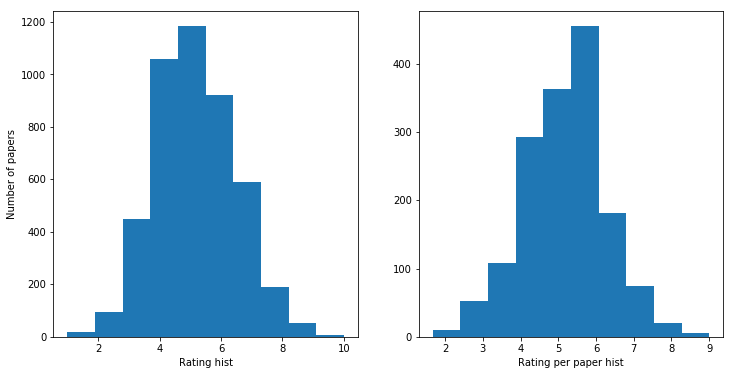

In [5]:
# Plot histograms of ratings
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(rating, bins=10)
plt.xlabel('Rating hist')
plt.ylabel('Number of papers')
plt.subplot(122)
plt.hist(rating_mean, bins=10)
plt.xlabel('Rating per paper hist')
plt.show()

In [6]:
# See how many papers are beaten by yours
def PR(rating_mean, your_rating):
    pr = np.sum(your_rating >= np.array(rating_mean))/len(rating_mean)*100
    return pr
my_rating = (5+6+7)/3  # your average rating here
print('Your papar beats {:.2f}% of submission '
      '(well, jsut based on the ratings...)'.format(PR(rating_mean, my_rating)))


# ICLR 2017: accept rate 39.1% (198/507) (15 orals and 183 posters)
# ICLR 2018: accept rate 32% (314/981) (23 orals and 291 posters)
# ICLR 2018: accept rate ?% (?/1580)

Your papar beats 82.02% of submission (well, jsut based on the ratings...)


In [7]:
# Count keywords
from collections import Counter
keywords_hist = Counter(keywords)
del keywords_hist['']
print('{} different keywords before merging'.format(len(keywords_hist)))

# Merge duplicates: CNNs and CNN
duplicates = []
for k in keywords_hist:
    if k+'s' in keywords_hist:
        duplicates.append(k)
for k in duplicates:
    keywords_hist[k] += keywords_hist[k+'s']
    del keywords_hist[k+'s']
# print('Merge: {}'.format([d+'s' for d in duplicates]))
print('{} different keywords after merging'.format(len(keywords_hist)))

2872 different keywords before merging
2768 different keywords after merging


In [8]:
# Create keywords list
keywords_list = []
keywords_key_list = []
for m in meta_list:
    for k in [mk for mk in m.keyword if not mk == '']:
        if k not in keywords_hist.keys():
            k = k[:-1]  # strip 's'
        if k in keywords_key_list:
            idx = keywords_key_list.index(k)
            keywords_list[idx].update_frequency(1)
            keywords_list[idx].update_rating(m.rating)
        else:
            # the keyword is new to the list
            k_object = Keyword(k, 1, m.rating)
            keywords_list.append(k_object)
            keywords_key_list.append(k_object.keyword)

65


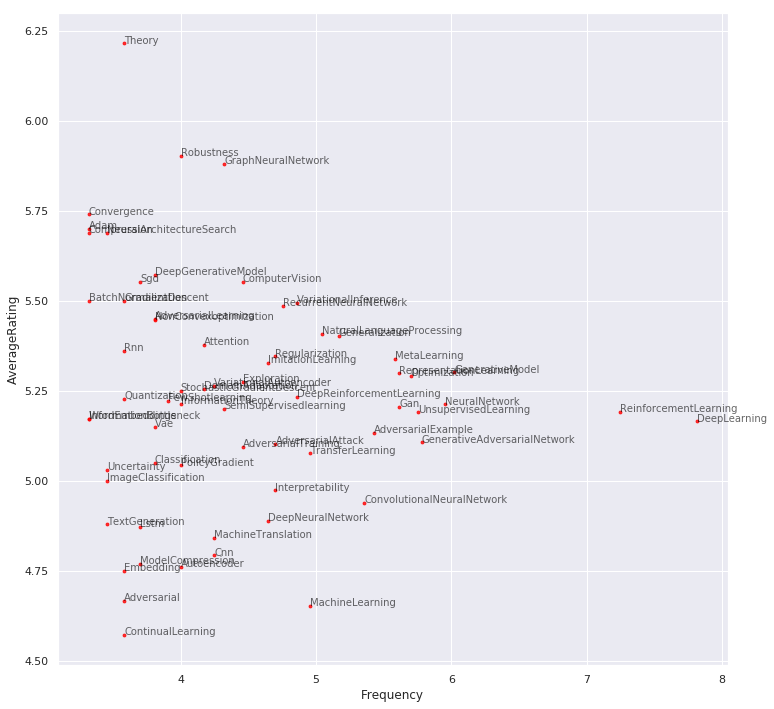

In [9]:
keywords_list_subset = [k for k in keywords_list if k.frequency > 9]
print(len(keywords_list_subset))
y = [k.average_rating() for k in keywords_list_subset]
x = [np.log2(k.frequency) for k in keywords_list_subset]
key = [k.keyword for k in keywords_list_subset]

# Create dataframe
df = pd.DataFrame({
'Frequency': x,
'AverageRating': y,
'Keyword': key
})

sns.set(font_scale=1)
fig = plt.figure(figsize=(12, 12))
p1 = sns.regplot(data=df, x="Frequency", y="AverageRating", fit_reg=False, 
                 marker="o", color="red", logx=True, scatter_kws={'s': 8})
for line in range(0, df.shape[0]):
     p1.text(df.Frequency[line], df.AverageRating[line], df.Keyword[line], 
             horizontalalignment='left', 
             size='small', color='black', alpha=0.6)
plt.show()

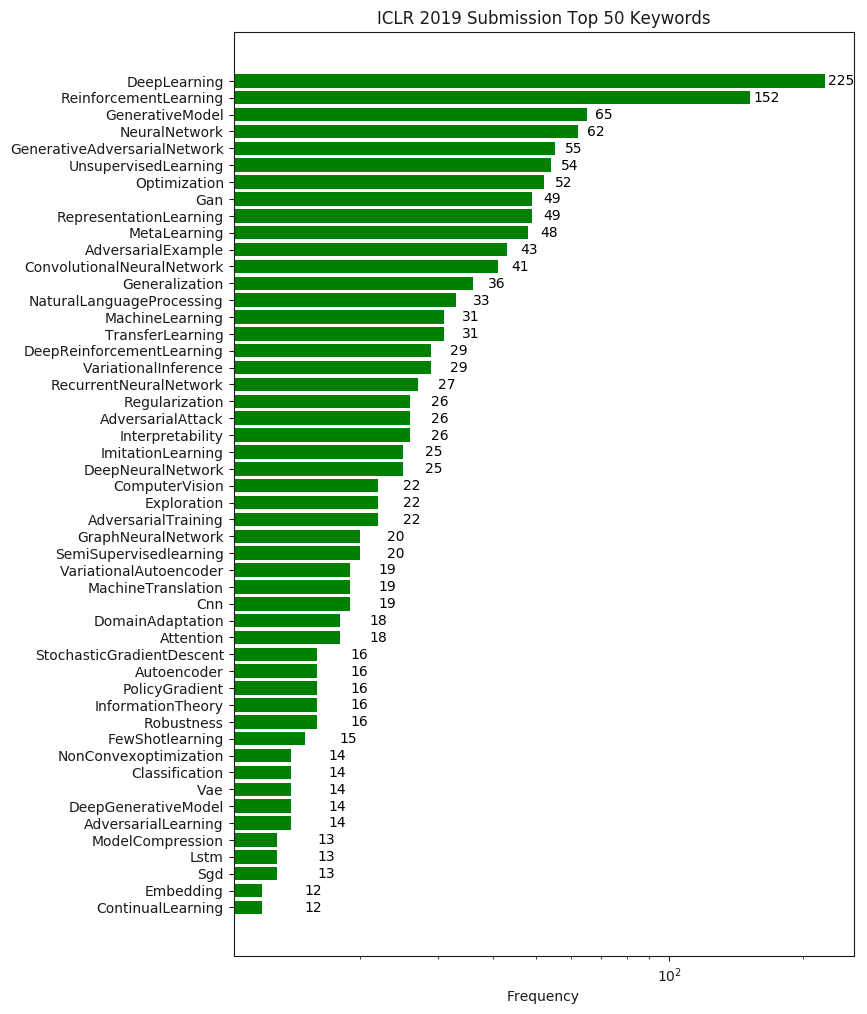

In [10]:
# Show N most common keywords and their frequencies
num_keyowrd = 50
keywords_hist_vis = keywords_hist.most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))

key = [k[0] for k in keywords_hist_vis] 
value = [k[1] for k in keywords_hist_vis] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('ICLR 2019 Submission Top {} Keywords'.format(num_keyowrd))

plt.show()

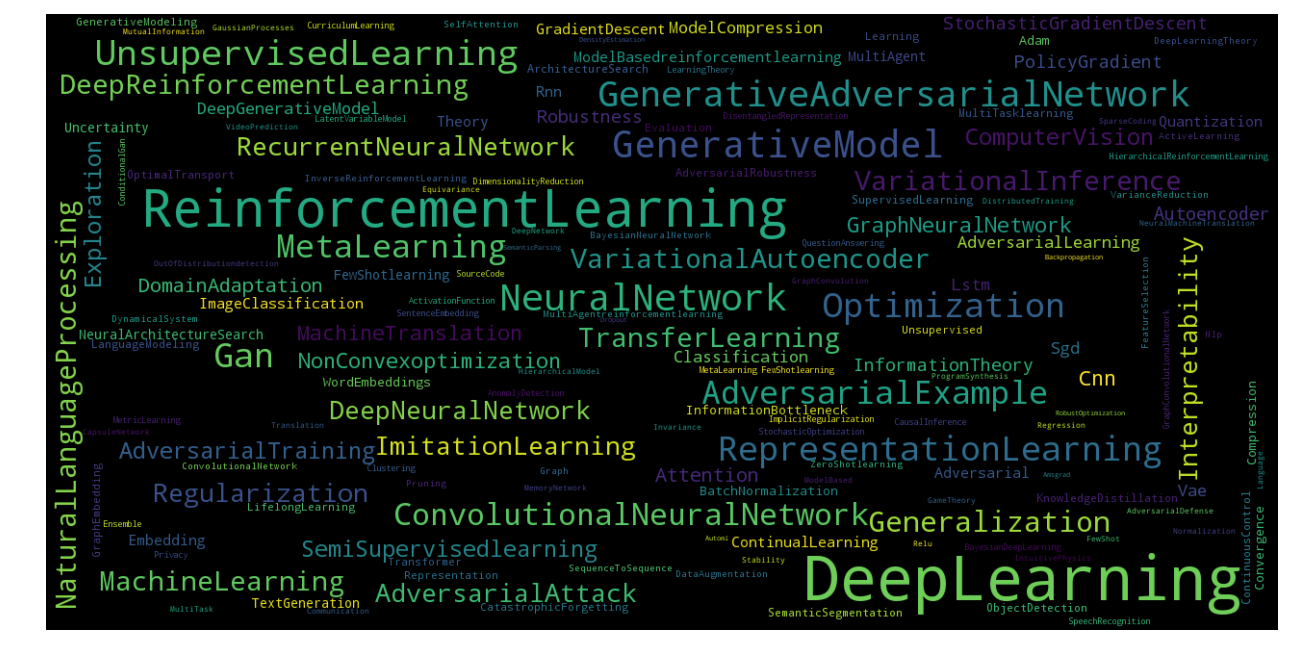

In [12]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=160, 
                      width=1280, height=640,
                      background_color="black").generate(' '.join(keywords))
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

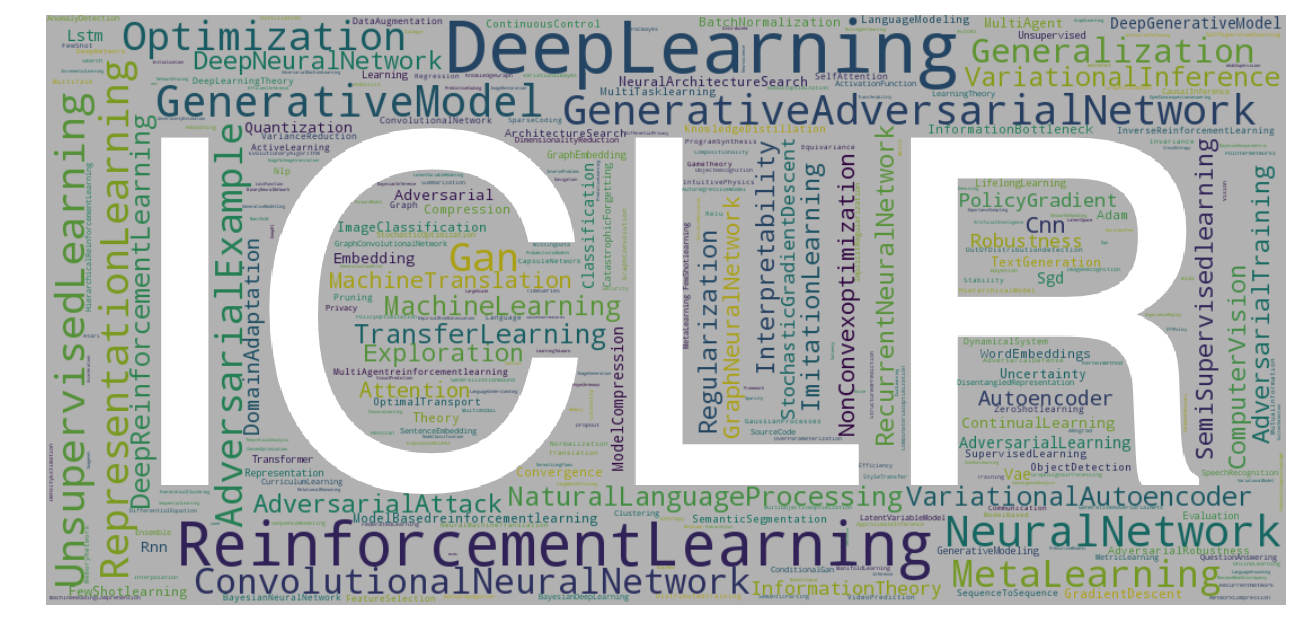

In [13]:
# Show the word cloud with an ICLR logo
from imageio import imread
logo = imread('logo.png')
wordcloud = WordCloud(max_font_size=64, max_words=300, 
                      width=1280, height=640,
                      background_color="white", mask=logo).generate(' '.join(keywords))
plt.figure(figsize=(16, 8), frameon=False)
plt.imshow(logo)
plt.imshow(wordcloud, interpolation="bilinear",  alpha=.7)
plt.axis("off")
plt.show()

In [14]:
num_valid = len(meta_list) - num_withdrawn
num_missing_rating = num_valid*3 - np.sum(np.clip(num_rating, 0, 3))
print('Number of missing reviews: {} ({:.4f}%)'.format(
    num_missing_rating, 100*float(num_missing_rating)/(num_valid*3)))

Number of missing reviews: 141 (3.0739%)


In [16]:
# Write all the data to README
import datetime
with open('README.md', 'r+') as readme:
    lines = readme.readlines()

data_title = '## <a id="Data"></a>All ICLR 2019 OpenReview data\n'
idx = lines.index(data_title)
lines = lines[:idx]

with open('README.md', 'w') as readme:
    for line in lines:
        readme.write(line)
    readme.write(data_title)
    readme.write('Collected at {}\n\n'.format(datetime.datetime.now()))
    readme.write('| Rank | Average Rating | Title | Ratings | Variance | \n')
    readme.write('| --- | --- | --- | --- | --- | \n')
    non_empty_rating_meta_list = [m for m in meta_list if not len(m.rating)==0]
    empty_rating_meta_list = [m for m in meta_list if len(m.rating)==0]    
    sorted_idx = np.argsort([np.mean(m.rating) for m in non_empty_rating_meta_list])[::-1]
    for i, idx in enumerate(sorted_idx):
        m = non_empty_rating_meta_list[idx]
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} |\n'.format(
            i+1, np.mean(m.rating), 
            m.title if not m.withdrawn else '~~'+m.title+'~~',  
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating)
        ))
    for i, m in enumerate(empty_rating_meta_list):
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} |\n'.format(
            i+1+len(non_empty_rating_meta_list), np.mean(m.rating), 
            m.title if not m.withdrawn else '~~'+m.title+'~~',
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating)
        ))

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
